<a href="https://colab.research.google.com/github/tornikeo/lut-gpgpu-course/blob/main/gpgpu_e3_tornikeo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Student: Tornike Onoprishvili   
Exercise 4. `The sparse, the dense and the ugly`

In [1]:
from math import ceil as roof # Very important!
import numpy as np
import cupy as cp
from cupy import cuda
assert cuda.is_available()

## Task 1:

Sparse matrices.

- Compare the memory footprint of matrices in dense, COO and CSR -formats. Plot the amount of stored elements against the total number of elements in the matrix. Use sparse matrices with density of 0.01. Use different square matrix sizes to show the difference.

Hint: For COO and CSR formats you will have to find the sizes of vectors they store the data. Check out CuPy Sparse reference.


/tmp/ipykernel_84967/2780503313.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


Text(0, 0.5, 'nbytes')

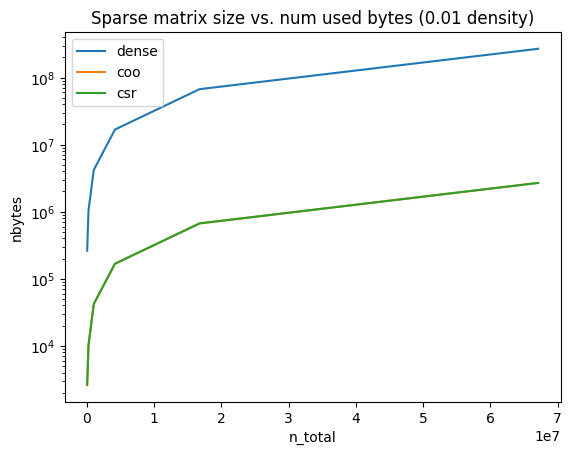

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
cp.random.seed(42)
np.random.seed(42)

df = []
for p in np.arange(8, 14, dtype='int32'):
    n = 2 ** p
    a = cp.random.uniform(0, 1, size=(n,n), dtype='float32')
    sparse_mask = cp.random.uniform(0, 1, size=a.shape) < .01
    a_dense = a * sparse_mask
    a_coo = cp.sparse.coo_matrix(a_dense)
    a_csr = a_coo.tocsr(copy=True)
    row = []
    n_total = n * n
    for mat in [a_dense, a_coo, a_csr]:
        if mat is not a_dense:
            n_stored = mat.data.nbytes
        else:
            n_stored = mat.nbytes
        row.append(n_stored)
    row.append(n_total)
    df.append( pd.Series(row) )
    
df = pd.concat(df, axis=1).T
df.columns = ['dense', 'coo', 'csr', 'n_total']

# sns.lineplot(data=df, x='n_total', y=['dense','coo','csr'])

df.plot(x = 'n_total')
plt.title('Sparse matrix size vs. num used bytes (0.01 density)')
plt.yscale('log')
plt.ylabel('nbytes')

Comments from Tornikeo: 

> Explanation for this plot - COO and CSR formats only store O(n_nonzero) amount of elements. A dense matrix, is, well, dense. It stores O(nrows * ncols) regardless of the nature of elements (the fact that they are mostly meaningless isn't levereaged). Thus, sparse marices can be orders of magnitude larger than their dense counterparts. In this particular case, the order difference is roughly 2, because elements to zeros ratio is 10e-2.


- Compare the execution times of dot products between a matrix and a vector. Use four different cases for the matrix: Scipy dense, Scipy COO, CuPy dense and CuPy COO. The vector should be in dense-format in all cases.

Time their performance against different sizes of square matrices.

Why do the plots from a) and b) look the way they look? Which methods should be used when working on a GPU?

In [3]:
from contextlib import contextmanager
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

class FanciestTimerEver:
    """This is like the Rolex of python timers."""
    def __enter__(self):
        self.duration =- time.perf_counter()
        return self
    def __exit__(self, *args):
        self.duration += time.perf_counter()

Text(0, 0.5, 'a@b time (avg 100)')

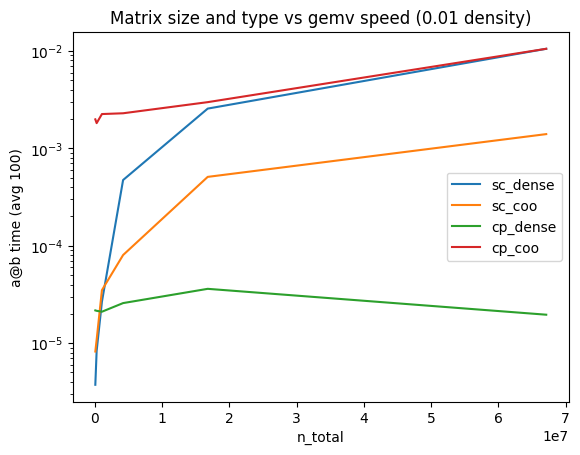

In [21]:
import scipy.sparse as sparse
cp.random.seed(42)
np.random.seed(42)

df = []
for p in np.arange(8, 14, dtype='int32'):
    n = 2 ** p
    a = cp.random.uniform(0, 1, size=(n,n), dtype='float32').get()
    sparse_mask = np.random.uniform(0, 1, size=a.shape) < .01
    
    sc_dense = np.array(a.copy())
    sc_coo = sparse.coo_matrix(a * sparse_mask)
    
    cp_dense = cp.array(sc_dense)
    cp_coo = cp.sparse.coo_matrix(cp.array(a * sparse_mask))
    
    row = []
    n_total = n * n
    for mat in [sc_dense, sc_coo, cp_dense, cp_coo]:
        if isinstance(mat, (np.ndarray, sparse.coo_matrix)):
            vec = np.random.uniform(0, 1, size=(n,1)).astype('float32')
        else:
            vec = cp.random.uniform(0, 1, size=(n,1), dtype='float32')
        # Warmup for kernel
        res = mat.dot(vec)
        with FanciestTimerEver() as timer:
            for _ in range(100):
                res = mat.dot(vec)
        row.append(timer.duration / 100)
    row.append(n_total)
    df.append( pd.Series(row) )
    
df = pd.concat(df, axis=1).T
df.columns = ['sc_dense','sc_coo','cp_dense','cp_coo','n_total']

df.plot(x = 'n_total')
plt.title('Matrix size and type vs gemv speed (0.01 density)')
plt.yscale('log')
plt.ylabel('a@b time (avg 100)')

Text(0, 0.5, 'a@b time (avg 100)')

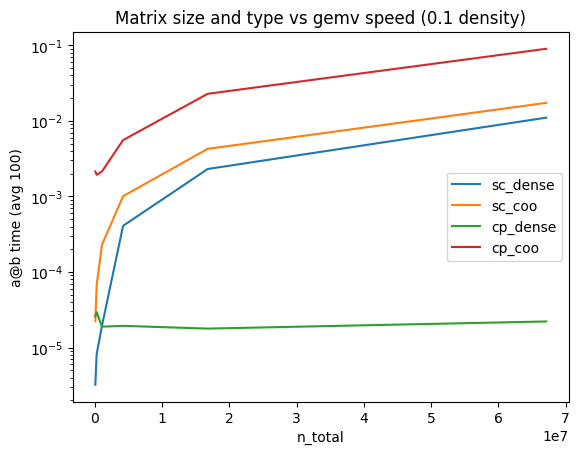

In [22]:
# Let's also see performance for 10% sparsity!

cp.random.seed(42)
np.random.seed(42)

df = []
for p in np.arange(8, 14, dtype='int32'):
    n = 2 ** p
    a = cp.random.uniform(0, 1, size=(n,n), dtype='float32').get()
    sparse_mask = np.random.uniform(0, 1, size=a.shape) < .1
    
    sc_dense = np.array(a.copy())
    sc_coo = sparse.coo_matrix(a * sparse_mask)
    
    cp_dense = cp.array(sc_dense)
    cp_coo = cp.sparse.coo_matrix(cp.array(a * sparse_mask))
    
    row = []
    n_total = n * n
    for mat in [sc_dense, sc_coo, cp_dense, cp_coo]:
        if isinstance(mat, (np.ndarray, sparse.coo_matrix)):
            vec = np.random.uniform(0, 1, size=(n,1)).astype('float32')
        else:
            vec = cp.random.uniform(0, 1, size=(n,1), dtype='float32')
        # Warmup for kernel
        res = mat.dot(vec)
        with FanciestTimerEver() as timer:
            for _ in range(100):
                res = mat.dot(vec)
        row.append(timer.duration / 100)
    row.append(n_total)
    df.append( pd.Series(row) )
    
df = pd.concat(df, axis=1).T
df.columns = ['sc_dense','sc_coo','cp_dense','cp_coo','n_total']

df.plot(x = 'n_total')
plt.title('Matrix size and type vs gemv speed (0.1 density)')
plt.yscale('log')
plt.ylabel('a@b time (avg 100)')

Comments from Tornikeo: 

Explanation for this plot - Dense matmul is likely the most optimized algorithm in the history of computing. Not surprising to see it come out on top.


For 0.01 density:

- Dense matmul on GPU performs fastest, as long as the gpu can fit all intermediate results.
- Next fastest is scipy coo matmul. I believe this is because at these scales ~1e8 the CPU SIMD instructions are outperforming GPUs. I would expect that in much larger sparse matrices we would see cp_coo to start outperforming sc_coo.
- And last, we have sc_dense and cp_coo very close together. I think this is just a coincidence these two are very close, I think this is caused by this particular denisity. Let's test higher denisities.

For 0.1 density:
- Dense matmul is still fastest, no surprise there.
- sc operations (dense and coo) are now very similar
- cp coo becomes quite a bit slower... I think this could be because of some internal CuPy implementation decisions? I have no idea why it is the slowest.
